# [Phystech@DataScience](https://thetahat.ru/courses/ph-ds-2025-spr)

## Валидация и метрики качества

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold,\
                                    ShuffleSplit,\
                                    StratifiedKFold,\
                                    StratifiedShuffleSplit,\
                                    GroupKFold,\
                                    GroupShuffleSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import seaborn as sns
sns.set_theme(style='dark', font_scale=1.3)

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Bot check

# HW_ID: phds_sem5
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

### 1.  Cкачаем [датасет](https://www.kaggle.com/colearninglounge/predicting-pulsar-starintermediate) о предсказании пульсаров.

Пульсары &mdash; это космические объекты, излучающие в различных диапазонах длины волны. Согласно современным астрофизическим теориям, пульсары представляют собой вращающиеся нейтронные звезды, обладающие магнитным полем, наклоненным относительно оси вращения.

Пульсары представляют значительный научный интерес. Поэтому есть потребность в автоматической идентификации интересных объектов для ускорения процесса изучения. На практике почти все обнаружения вызваны радиочастотными помехами и шумом, что затрудняет поиск достоверных сигналов. В последнее время для автоматического обнаружения пульсаров начали применять машинное обучение. Актуальная задача сегодня &mdash; бинарная классификация объектов-кандидатов на предмет того, являются ли они пульсарами.

В используемом датасете есть как примеры ложных обнаружений, так и примеры реальных пульсаров, подтвержденные учеными. Данные получены в результате [The High Time Resolution Universe Pulsar Survey I](https://arxiv.org/abs/1006.5744).

Мы будем работать только с файлом `pulsar_data_train.csv`.

In [14]:
data = pd.read_csv("pulsar_data_train.csv")

Сигнал от пульсаров представляет собой периодические импульсы.

Для описания объекта используется integrated profile (интегральный профиль) &mdash; агрегирование сигнала за разные периоды вращения (<a target="_blank" href="http://ipta.phys.wvu.edu/files/student-week-2017/IPTA2017_KuoLiu_pulsartiming.pdf">ссылка</a>, слайд 11). У всех пульсаров разные интегральные профили, и обычно эта характеристика мало меняется во времени.
В данном датасете интегральный профиль также усреднен по частоте.

Кроме того, импульс приходит в разное время на разных частотах. Задержка от частоты к частоте вызвана наличием ионизированной межзвездной среды и называется дисперсией. Не путать с дисперсией в теории вероятностей.

С дисперсией связана еще одна характеристика объекта &mdash; DM-SNR кривая. Подробнее о ней можно почитать <a target="_blank" href="https://arxiv.org/pdf/1005.5068.pdf#:~:text=period-DM%20diagram%3B%20good%20agreement,pulsars%20in%20their%20candidate%20plots.)">в специализированных материалах</a>.

Обе характеристики, integrated profile и DM-SNR кривая, представляют собой одномерные функции.
При создании датасета значения функций были посчитаны в конечном количестве $n$ точек.
Фактически, были получены реализации выборки двух случайных величин.

Пусть $P = (p_1, \ldots p_n)$ &mdash; массив значений integrated profile.
Для него можно посчитать следующие величины:

1.   Выборочное среднее $\bar p = \frac{1}{n}\sum \limits_{i=1}^n p_i$;
2.   Выборочное стандартное отклонение $\sqrt{\frac{1}{n}\sum \limits_{i=1}^n (p_i - \bar p)^2}$;
3. Выборочный коэффициент асимметрии (skewness);
4. Выборочный коэффициент эксцесса (kurtosis).

Для $D = (d_1, \ldots d_n)$, массива значений DM-SNR, аналогично.

Именно эти значения по массивам $P$ и $D$ являются признаками в данном датасете.

Про коэффициенты эксцесса и асимметрии можно посмотреть <a target="_blank" href="https://ru.wikipedia.org/wiki/%D0%9A%D0%BE%D1%8D%D1%84%D1%84%D0%B8%D1%86%D0%B8%D0%B5%D0%BD%D1%82_%D1%8D%D0%BA%D1%81%D1%86%D0%B5%D1%81%D1%81%D0%B0">здесь</a> и <a target="_blank" href="https://ru.wikipedia.org/wiki/%D0%9A%D0%BE%D1%8D%D1%84%D1%84%D0%B8%D1%86%D0%B8%D0%B5%D0%BD%D1%82_%D0%B0%D1%81%D0%B8%D0%BC%D0%BC%D0%B5%D1%82%D1%80%D0%B8%D0%B8">здесь</a>, формулы для выборочных коэффициентов асимметрии и эксцесса можно найти в английской версии этих статей.

<a target="_blank" href="https://arxiv.org/pdf/1603.05166.pdf">Статья</a> с подробным описанием процесса генерации данных.










In [15]:
data.head()

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
0,121.156250,48.372971,0.375485,-0.013165,3.168896,18.399367,7.449874,65.159298,0.0
1,76.968750,36.175557,0.712898,3.388719,2.399666,17.570997,9.414652,102.722975,0.0
2,130.585938,53.229534,0.133408,-0.297242,2.743311,22.362553,8.508364,74.031324,0.0
3,156.398438,48.865942,-0.215989,-0.171294,17.471572,NaN,2.958066,7.197842,0.0
4,84.804688,36.117659,0.825013,3.274125,2.790134,20.618009,8.405008,76.291128,0.0


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12528 entries, 0 to 12527
Data columns (total 9 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0    Mean of the integrated profile                12528 non-null  float64
 1    Standard deviation of the integrated profile  12528 non-null  float64
 2    Excess kurtosis of the integrated profile     10793 non-null  float64
 3    Skewness of the integrated profile            12528 non-null  float64
 4    Mean of the DM-SNR curve                      12528 non-null  float64
 5    Standard deviation of the DM-SNR curve        11350 non-null  float64
 6    Excess kurtosis of the DM-SNR curve           12528 non-null  float64
 7    Skewness of the DM-SNR curve                  11903 non-null  float64
 8   target_class                                   12528 non-null  float64
dtypes: float64(9)
memory usage: 881.0 KB


### 2. Предобработаем данные.

В этом датасете в некоторых столбцах есть пропуски в данных. Об этом говорит то, что значение Non-Null Count в таблице выше не равно количеству строк для некоторых столбцов. Чтобы не усложнять себе жизнь, пока просто не будем брать эти столбцы для анализа.

Посчитаем число пропусков в каждой колонке:

In [17]:
data.isna().sum()

 Mean of the integrated profile                     0
 Standard deviation of the integrated profile       0
 Excess kurtosis of the integrated profile       1735
 Skewness of the integrated profile                 0
 Mean of the DM-SNR curve                           0
 Standard deviation of the DM-SNR curve          1178
 Excess kurtosis of the DM-SNR curve                0
 Skewness of the DM-SNR curve                     625
target_class                                        0
dtype: int64

Удалите все соответствующие строчки:

In [18]:
data = data.dropna(axis=1)

Теперь возьмем только некоторые столбцы в качестве независимых переменных и выделим зависимую. Столбец `target_class` отвечает за целевую переменную — индикатор того, является ли объект пульсаром.

In [19]:
needed_columns = [' Mean of the integrated profile',
       ' Standard deviation of the integrated profile',
       ' Skewness of the integrated profile', ' Mean of the DM-SNR curve',
       ' Excess kurtosis of the DM-SNR curve']  # используем только эти столбцы

X = data[needed_columns]
y = data["target_class"]

y.value_counts()

target_class
0.0    11375
1.0     1153
Name: count, dtype: int64

### 3. Графики

Проведем визуальный анализ данных. Построим оценки плотности по каждому признаку отдельно для каждого класса. Какие признаки лучше всего разделяют классы? Как это отразится на результатах модели?

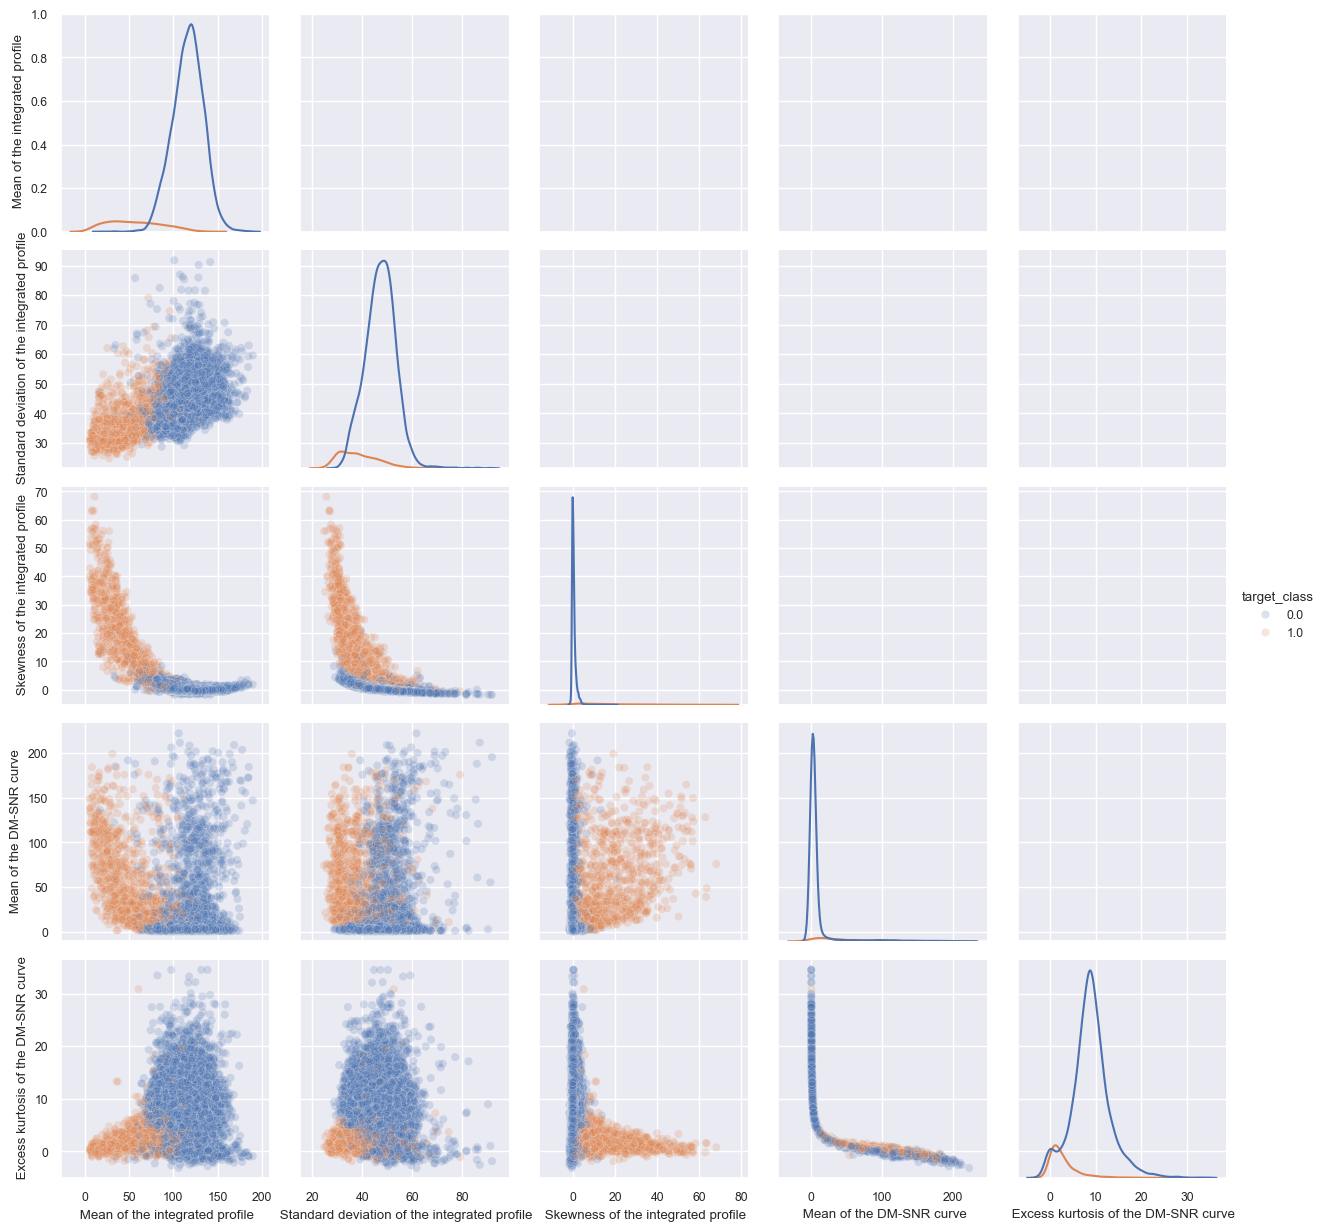

In [20]:
sns.set_theme(font_scale=0.8)

plot = sns.PairGrid(data, x_vars=needed_columns, y_vars=needed_columns,
                    hue="target_class", diag_sharey=False)

plot.map_diag(sns.kdeplot)
plot.map_lower(sns.scatterplot, alpha=0.2)
plot.add_legend();

**Ответ:** Mean of the integrated profile и Skewness of the integrated profile, так как для этих признаков попарные разделения наиболее очевидные

### 4. Разделим датасет

Случайно разделим выборку на обучающую и тестовую части в соотношении 4:1.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((10022, 5), (2506, 5), (10022,), (2506,))

### 5. Подберем оптимальные гиперпараметры

Будем подбирать гиперпараметры для модели решающего дерева.

* Задайте сетку гиперпараметров (определите, какие гиперпараметры вам нужны на основании материалов предыдущего занятия) для перебора.

* Выберите стратегию кросс-валидации.
* Выберите метод поиска оптимальных гиперпараметров &mdash; `GridSearchCV` или `RandomizedSearchCV` &mdash; раскомментируйте нужный блок кода.
* Выберите оптимизируемую метрику ([параметр `scoring`](https://scikit-learn.org/stable/modules/model_evaluation.html#using-multiple-metric-evaluation) в `GridSearchCV`, `RandomizedSearchCV`, список названий доступных метрик приведен ниже).

Объясните каждый свой выбор.

In [22]:
sklearn.metrics.get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'd2_absolute_error_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'neg_root_mean_squared_log_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall

**Ответ:** Берём precision потому что на практике почти все обнаружения вызваны радиочастотными помехами и шумом, что затрудняет поиск достоверных сигналов

In [24]:
# словарь параметров
parameters_grid = {'max_depth':range(1, 20),
              'min_samples_split':range(2, 11),
              'max_features':list(range(1, 11)) + [None, 'log2', 'sqrt']}

# задаем стратегию кросс-валидации
cv_strategy = 5

# задаем имя метрики для максимизации, str
scorer_name = 'precision'

# задаем модель
model = DecisionTreeClassifier()

# определяем поиск по сетке
search = RandomizedSearchCV(
    # модель для обучения
    estimator=model,
    # сетка значений гиперпараметров
    param_distributions=parameters_grid,
    # сколько комбинаций признаков будет проверено
    n_iter=100,
    # метрика качества, можно задать строкой
    scoring=scorer_name,
    # GridSearchCV, RandomizedSearchCV отлично параллелятся на несколько ядер
    # n_jobs=-1 означает, что мы используем все доступные ядра
    n_jobs=-1,
    # стратегия кросс-валидации
    cv=cv_strategy,
    # сообщения с логами обучения: больше значение - больше сообщений
    verbose=10,
    # значение, присваиваемое scorer в случае ошибки при обучении
    error_score='raise'
)


# определяем поиск по сетке
search = GridSearchCV(
    # модель для обучения
    estimator=model,
    # сетка значений гиперпараметров
    param_grid=parameters_grid,
    # метрика качества, можно задать строкой
    scoring=scorer_name,
    # GridSearchCV, RandomizedSearchCV отлично параллелятся на несколько ядер
    # n_jobs=-1 означает, что мы используем все доступные ядра
    n_jobs=-1,
    # стратегия кросс-валидации
    cv=cv_strategy,
    # сообщения с логами обучения: больше значение - больше сообщений
    verbose=10,
    # значение, присваиваемое scorer в случае ошибки при обучении
    error_score='raise'
)

In [25]:
%%time
# выполняем поиск по сетке
# обучаем, конечно, не тренировочной части данных
search.fit(X_train, y_train)

Fitting 5 folds for each of 2223 candidates, totalling 11115 fits
CPU times: total: 8.66 s
Wall time: 1min 12s


GridSearchCV(cv=5, error_score='raise', estimator=DecisionTreeClassifier(),
             n_jobs=-1,
             param_grid={'max_depth': range(1, 20),
                         'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None,
                                          'log2', 'sqrt'],
                         'min_samples_split': range(2, 11)},
             scoring='precision', verbose=10)

Итак, мы выполнили поиск гиперпараметров.

Выведите значения гиперпараметров лучшей модели:

In [26]:
search.best_params_

{'max_depth': 2, 'max_features': 4, 'min_samples_split': 6}

Выведите время обучения лучшей модели:

In [27]:
search.refit_time_

0.012896299362182617

 Визуализируйте лучшее дерево с помощью `sklearn.tree.plot_tree()`, что можно  о нем сказать?

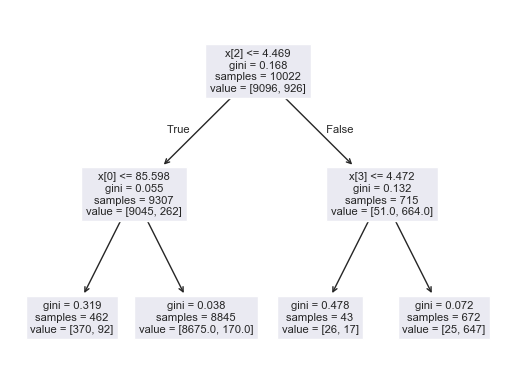

In [30]:
best_tree = sklearn.tree.plot_tree(search.best_estimator_)

Какое значение *оптимизируемой метрики* получилось достичь? Выведите значение **соответствующего атрибута** выбранного вами алгоритма поиска


In [31]:
print(search.best_score_)

0.957587001228102


Посчитайте precision, recall, f1-score, ROC-AUC на тестовой выборке при использовании лучшей модели. Что можно сказать о полученных результатах?

In [38]:
model = search.best_estimator_
y_pred = model.predict(X_test)

print(sklearn.metrics.recall_score(y_test, y_pred), 
     sklearn.metrics.f1_score(y_test, y_pred),
     sklearn.metrics.roc_auc_score(y_test, y_pred))

0.6916299559471366 0.8134715025906736 0.8453761890310497


**Выводы:** Наша модель хорошо научилась предсказывать для precision, но для recall значение совсем низкое, для остальных в пределах нормы